In [1]:
!sudo apt-get update
!sudo mkdir -p /usr/share/man/man1
!sudo apt-get install -y openjdk-11-jdk
!pip install pyspark


Hit:1 http://deb.debian.org/debian buster InRelease
Hit:2 http://deb.debian.org/debian-security buster/updates InRelease
Hit:3 http://deb.debian.org/debian buster-updates InRelease




openjdk-11-jdk is already the newest version (11.0.18+10-1~deb10u1).
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [68]:
#Importation des packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext
from pyspark.sql.functions import when

# I. Implémentation en spark du logiciel qui permet de calculer la prime assurance et une proposition d’un produit d'assurance.

In [3]:
# Création de la session Spark
spark = SparkSession.builder.appName("AssuranceApp").getOrCreate()

# Chargement du dataset
df = spark.read.csv("Car_Insurance.csv", header=True, inferSchema=True)


# Définir les colonnes pertinentes pour le calcul de la prime d'assurance
relevant_columns = ["CREDIT_SCORE", "ANNUAL_MILEAGE", "MARRIED", "PAST_ACCIDENTS", "DUIS", "SPEEDING_VIOLATIONS"]

# Calculer la prime d'assurance
df = df.withColumn("PrimeAssurance", when((df["MARRIED"] == 1) & (df["PAST_ACCIDENTS"] == 0) & (df["DUIS"] == 0), 1000)
                     .when((df["MARRIED"] == 0.0) & (df["PAST_ACCIDENTS"] == 0) & (df["DUIS"] == 0), 1500)
                     .when((df["MARRIED"] == 0.0) & (df["PAST_ACCIDENTS"] > 0), 2000)
                     .when((df["MARRIED"] == 0.0) & (df["DUIS"] > 0), 2500)
                     .otherwise(3000))


# Proposer un produit d'assurance en fonction de la prime d'assurance
df = df.withColumn("ProduitAssurance", when(df["PrimeAssurance"] <= 1500, "Assurance responsabilité civile")
                     .when((df["PrimeAssurance"] > 1500) & (df["PrimeAssurance"] <= 2500), "Assurance standard")
                     .otherwise("Assurance tous risques"))

# Afficher le résultat final
df.show()





Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/05/26 08:10:41 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
+------+-----+------+--------+------------------+-----------+-------------+------------------+-----------------+------------+-------+--------+-----------+--------------+------------+-------------------+----+--------------+-------+--------------+--------------------+
|    ID|  AGE|GENDER|    RACE|DRIVING_EXPERIENCE|  EDUCATION|       INCOME|      CREDIT_SCORE|VEHICLE_OWNERSHIP|VEHICLE_YEAR|MARRIED|CHILDREN|POSTAL_CODE|ANNUAL_MILEAGE|VEHICLE_TYPE|SPEEDING_VIOLATIONS|DUIS|PAST_ACCIDENTS|OUTCOME|PrimeAssurance|    ProduitAssurance|
+------+-----+------+--------+------------------+-----------+-------------+------------------+-----------------+------------+-------+--------+-----------+--------------+------------+-----------

### Conversion du dataset spark en un dataset pandas pour la suite 

In [4]:
# Convertir le DataFrame Spark en DataFrame Pandas
dataset =df.toPandas()

In [5]:
dataset

,ID,AGE,GENDER,RACE,DRIVING_EXPERIENCE,EDUCATION,INCOME,CREDIT_SCORE,VEHICLE_OWNERSHIP,VEHICLE_YEAR,...,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,VEHICLE_TYPE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS,OUTCOME,PrimeAssurance,ProduitAssurance
0,569520,65+,female,majority,0-9y,high school,upper class,0.629027,1.0,after 2015,...,1.0,10238,12000.0,sedan,0,0,0,0.0,1500,Assurance responsabilité civile
1,750365,16-25,male,majority,0-9y,none,poverty,0.357757,0.0,before 2015,...,0.0,10238,16000.0,sedan,0,0,0,1.0,1500,Assurance responsabilité civile
2,199901,16-25,female,majority,0-9y,high school,working class,0.493146,1.0,before 2015,...,0.0,10238,11000.0,sedan,0,0,0,0.0,1500,Assurance responsabilité civile
3,478866,16-25,male,majority,0-9y,university,working class,0.206013,1.0,before 2015,...,1.0,32765,11000.0,sedan,0,0,0,0.0,1500,Assurance responsabilité civile
4,731664,26-39,male,majority,10-19y,none,working class,0.388366,1.0,before 2015,...,0.0,32765,12000.0,sedan,2,0,1,1.0,2000,Assurance standard
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,323164,26-39,female,majority,10-19y,university,upper class,0.582787,1.0,before 2015,...,0.0,10238,16000.0,sedan,0,0,1,0.0,2000,Assurance standard
9996,910346,26-39,female,majority,10-19y,none,middle class,0.522231,1.0,after 2015,...,1.0,32765,NaN,sedan,1,0,0,0.0,1500,Assurance responsabilité civile
9997,468409,26-39,male,majority,0-9y,high school,middle class,0.470940,1.0,before 2015,...,1.0,10238,14000.0,sedan,0,0,0,0.0,1500,Assurance responsabilité civile
9998,903459,26-39,female,majority,10-19y,high school,poverty,0.364185,0.0,before 2015,...,1.0,10238,13000.0,sedan,2,0,1,1.0,2000,Assurance standard


In [6]:
distinct_values = dataset['ProduitAssurance'].unique()
print(distinct_values)

['Assurance responsabilité civile' 'Assurance standard'
 'Assurance tous risques']


In [7]:
#Voir les valeurs manquantes
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   10000 non-null  int32  
 1   AGE                  10000 non-null  object 
 2   GENDER               10000 non-null  object 
 3   RACE                 10000 non-null  object 
 4   DRIVING_EXPERIENCE   10000 non-null  object 
 5   EDUCATION            10000 non-null  object 
 6   INCOME               10000 non-null  object 
 7   CREDIT_SCORE         9018 non-null   float64
 8   VEHICLE_OWNERSHIP    10000 non-null  float64
 9   VEHICLE_YEAR         10000 non-null  object 
 10  MARRIED              10000 non-null  float64
 11  CHILDREN             10000 non-null  float64
 12  POSTAL_CODE          10000 non-null  int32  
 13  ANNUAL_MILEAGE       9043 non-null   float64
 14  VEHICLE_TYPE         10000 non-null  object 
 15  SPEEDING_VIOLATIONS  10000 non-null  

In [8]:
dataset.isnull().sum().sort_values(ascending=False)

CREDIT_SCORE           982
ANNUAL_MILEAGE         957
ID                       0
CHILDREN                 0
PrimeAssurance           0
OUTCOME                  0
PAST_ACCIDENTS           0
DUIS                     0
SPEEDING_VIOLATIONS      0
VEHICLE_TYPE             0
POSTAL_CODE              0
MARRIED                  0
AGE                      0
VEHICLE_YEAR             0
VEHICLE_OWNERSHIP        0
INCOME                   0
EDUCATION                0
DRIVING_EXPERIENCE       0
RACE                     0
GENDER                   0
ProduitAssurance         0
dtype: int64

In [9]:
#Valeurs anormales
dataset.describe()

,ID,CREDIT_SCORE,VEHICLE_OWNERSHIP,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS,OUTCOME,PrimeAssurance
count,10000.000000,9018.000000,10000.000000,10000.000000,10000.000000,10000.000000,9043.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,500521.906800,0.515813,0.697000,0.498200,0.688800,19864.548400,11697.003207,1.482900,0.23920,1.056300,0.313300,1957.700000
std,290030.768758,0.137688,0.459578,0.500022,0.463008,18915.613855,2818.434528,2.241966,0.55499,1.652454,0.463858,761.228387
min,101.000000,0.053358,0.000000,0.000000,0.000000,10238.000000,2000.000000,0.000000,0.00000,0.000000,0.000000,1000.000000
25%,249638.500000,0.417191,0.000000,0.000000,0.000000,10238.000000,10000.000000,0.000000,0.00000,0.000000,0.000000,1500.000000
50%,501777.000000,0.525033,1.000000,0.000000,1.000000,10238.000000,12000.000000,0.000000,0.00000,0.000000,0.000000,1500.000000
75%,753974.500000,0.618312,1.000000,1.000000,1.000000,32765.000000,14000.000000,2.000000,0.00000,2.000000,1.000000,3000.000000
max,999976.000000,0.960819,1.000000,1.000000,1.000000,92101.000000,22000.000000,22.000000,6.00000,15.000000,1.000000,3000.000000


In [10]:
#Variables Catégoriques
dataset.describe(include='O')

,AGE,GENDER,RACE,DRIVING_EXPERIENCE,EDUCATION,INCOME,VEHICLE_YEAR,VEHICLE_TYPE,ProduitAssurance
count,10000,10000,10000,10000,10000,10000,10000,10000,10000
unique,4,2,2,4,3,4,2,2,3
top,26-39,female,majority,0-9y,high school,upper class,before 2015,sedan,Assurance responsabilité civile
freq,3063,5010,9012,3530,4157,4336,6967,9523,5079


In [11]:
#Je divise ma base de données en 2; Dans une base je mets les variables catégoriques et dans l'autre base je mets les variables numériques
cat_data = []
num_data = []

for i,c in enumerate(dataset.dtypes):
    if c == object:
        cat_data.append(dataset.iloc[:,i])
    else:
        num_data.append(dataset.iloc[:,i])
cat_data = pd.DataFrame(cat_data).transpose()
num_data = pd.DataFrame(num_data).transpose()

In [12]:
#Je vérifie s'il y'a encore les valeurs manquantes dans mes variables catégoriques
cat_data.isnull().sum().any()

False

In [13]:
pip install pickle

ERROR: Could not find a version that satisfies the requirement pickle (from versions: none)
ERROR: No matching distribution found for pickle
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [14]:
#Remplacer les valeurs catégoriques par des valeurs numériques 0,1...
le = LabelEncoder()
for i in cat_data:
    cat_data[i] = le.fit_transform(cat_data[i])
cat_data

,AGE,GENDER,RACE,DRIVING_EXPERIENCE,EDUCATION,INCOME,VEHICLE_YEAR,VEHICLE_TYPE,ProduitAssurance
0,3,0,0,0,0,2,0,0,0
1,0,1,0,0,1,1,1,0,0
2,0,0,0,0,0,3,1,0,0
3,0,1,0,0,2,3,1,0,0
4,1,1,0,1,1,3,1,0,1
...,...,...,...,...,...,...,...,...,...
9995,1,0,0,1,2,2,1,0,1
9996,1,0,0,1,1,0,0,0,0
9997,1,1,0,0,0,0,1,0,0
9998,1,0,0,1,0,1,1,0,1


In [15]:
#Pour les variables numériques, on va remplacer les valeurs manquantes par la valeur précédente de la même colonne
num_data.fillna(method='bfill', inplace=True)
#Je vérifie s'il y'a encore les valeurs manquantes
num_data.isnull().sum().any()

False

In [16]:
#Concatener cat_data et num_data
data = pd.concat([cat_data,num_data],axis=1)
data

,AGE,GENDER,RACE,DRIVING_EXPERIENCE,EDUCATION,INCOME,VEHICLE_YEAR,VEHICLE_TYPE,ProduitAssurance,ID,...,VEHICLE_OWNERSHIP,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS,OUTCOME,PrimeAssurance
0,3,0,0,0,0,2,0,0,0,569520.0,...,1.0,0.0,1.0,10238.0,12000.0,0.0,0.0,0.0,0.0,1500.0
1,0,1,0,0,1,1,1,0,0,750365.0,...,0.0,0.0,0.0,10238.0,16000.0,0.0,0.0,0.0,1.0,1500.0
2,0,0,0,0,0,3,1,0,0,199901.0,...,1.0,0.0,0.0,10238.0,11000.0,0.0,0.0,0.0,0.0,1500.0
3,0,1,0,0,2,3,1,0,0,478866.0,...,1.0,0.0,1.0,32765.0,11000.0,0.0,0.0,0.0,0.0,1500.0
4,1,1,0,1,1,3,1,0,1,731664.0,...,1.0,0.0,0.0,32765.0,12000.0,2.0,0.0,1.0,1.0,2000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1,0,0,1,2,2,1,0,1,323164.0,...,1.0,0.0,0.0,10238.0,16000.0,0.0,0.0,1.0,0.0,2000.0
9996,1,0,0,1,1,0,0,0,0,910346.0,...,1.0,0.0,1.0,32765.0,14000.0,1.0,0.0,0.0,0.0,1500.0
9997,1,1,0,0,0,0,1,0,0,468409.0,...,1.0,0.0,1.0,10238.0,14000.0,0.0,0.0,0.0,0.0,1500.0
9998,1,0,0,1,0,1,1,0,1,903459.0,...,0.0,0.0,1.0,10238.0,13000.0,2.0,0.0,1.0,1.0,2000.0


## Analyse Exploratoire du Dataset

In [18]:
dataset.columns

Index(['ID', 'AGE', 'GENDER', 'RACE', 'DRIVING_EXPERIENCE', 'EDUCATION',
       'INCOME', 'CREDIT_SCORE', 'VEHICLE_OWNERSHIP', 'VEHICLE_YEAR',
       'MARRIED', 'CHILDREN', 'POSTAL_CODE', 'ANNUAL_MILEAGE', 'VEHICLE_TYPE',
       'SPEEDING_VIOLATIONS', 'DUIS', 'PAST_ACCIDENTS', 'OUTCOME',
       'PrimeAssurance', 'ProduitAssurance'],
      dtype='object')

In [33]:
data1=dataset.drop(['ID','PrimeAssurance','ProduitAssurance','POSTAL_CODE','DUIS'], axis=1)

In [34]:
data1=data1.fillna(data1.mean())

In [35]:
# Remplissage des valeurs nulles 
data1.isna().sum()

AGE                    0
GENDER                 0
RACE                   0
DRIVING_EXPERIENCE     0
EDUCATION              0
INCOME                 0
CREDIT_SCORE           0
VEHICLE_OWNERSHIP      0
VEHICLE_YEAR           0
MARRIED                0
CHILDREN               0
ANNUAL_MILEAGE         0
VEHICLE_TYPE           0
SPEEDING_VIOLATIONS    0
PAST_ACCIDENTS         0
OUTCOME                0
dtype: int64

In [36]:
cat_data = data1.select_dtypes(include="object").columns
num_data = data1.select_dtypes(exclude="object").columns

In [37]:
data1.head()

,AGE,GENDER,RACE,DRIVING_EXPERIENCE,EDUCATION,INCOME,CREDIT_SCORE,VEHICLE_OWNERSHIP,VEHICLE_YEAR,MARRIED,CHILDREN,ANNUAL_MILEAGE,VEHICLE_TYPE,SPEEDING_VIOLATIONS,PAST_ACCIDENTS,OUTCOME
0,65+,female,majority,0-9y,high school,upper class,0.629027,1.0,after 2015,0.0,1.0,12000.0,sedan,0,0,0.0
1,16-25,male,majority,0-9y,none,poverty,0.357757,0.0,before 2015,0.0,0.0,16000.0,sedan,0,0,1.0
2,16-25,female,majority,0-9y,high school,working class,0.493146,1.0,before 2015,0.0,0.0,11000.0,sedan,0,0,0.0
3,16-25,male,majority,0-9y,university,working class,0.206013,1.0,before 2015,0.0,1.0,11000.0,sedan,0,0,0.0
4,26-39,male,majority,10-19y,none,working class,0.388366,1.0,before 2015,0.0,0.0,12000.0,sedan,2,1,1.0


# PIPELINES START

In [71]:
import sklearn
from sklearn.cluster import KMeans
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
transformers=ColumnTransformer([('numeric features transform',RobustScaler(),num_data),('categorical features transform',\
                                  OneHotEncoder(sparse=False,handle_unknown = 'ignore'),cat_data)])
#num_transform=ColumnTransformer([('numeric features transform',StandardScaler(),num_cols)])
#cat_transform=ColumnTransformer([])

In [39]:
pipe_t=Pipeline([('feat transforms',transformers),('Scaling',RobustScaler()),("kmean",KMeans(n_clusters=3, random_state=42))])
pipe_t

Pipeline(steps=[('feat transforms',
                 ColumnTransformer(transformers=[('numeric features transform',
                                                  RobustScaler(),
                                                  Index(['CREDIT_SCORE', 'VEHICLE_OWNERSHIP', 'MARRIED', 'CHILDREN',
       'ANNUAL_MILEAGE', 'SPEEDING_VIOLATIONS', 'PAST_ACCIDENTS', 'OUTCOME'],
      dtype='object')),
                                                 ('categorical features '
                                                  'transform',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  Index(['AGE', 'GENDER', 'RACE', 'DRIVING_EXPERIENCE', 'EDUCATION', 'INCOME',
       'VEHICLE_YEAR', 'VEHICLE_TYPE'],
      dtype='object'))])),
                ('Scaling', RobustScaler()),
                ('kmean', KMeans(n_clusters=3, random_state=42))])

## Kmeans

In [40]:
pipe_t.fit(data1)

Pipeline(steps=[('feat transforms',
                 ColumnTransformer(transformers=[('numeric features transform',
                                                  RobustScaler(),
                                                  Index(['CREDIT_SCORE', 'VEHICLE_OWNERSHIP', 'MARRIED', 'CHILDREN',
       'ANNUAL_MILEAGE', 'SPEEDING_VIOLATIONS', 'PAST_ACCIDENTS', 'OUTCOME'],
      dtype='object')),
                                                 ('categorical features '
                                                  'transform',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  Index(['AGE', 'GENDER', 'RACE', 'DRIVING_EXPERIENCE', 'EDUCATION', 'INCOME',
       'VEHICLE_YEAR', 'VEHICLE_TYPE'],
      dtype='object'))])),
                ('Scaling', RobustScaler()),
                ('kmean', KMeans(n_clusters=3, random_state=42))])

In [26]:
#Détermination de la valeur optimale de K
'''tab=[]
for i in range(1,10):
    pipe_t.fit(data1)
    tab.append(pipe_t.inertia_)
plt.plot(range(1,10),tab)
plt.title("La méthode Eblow")
plt.xlabel("nombre de cluster")
plt.ylabel("Inertie intra-classe")
plt.show()

'tab=[]\nfor i in range(1,10):\n    pipe_t.fit(data1)\n    tab.append(pipe_t.inertia_)\nplt.plot(range(1,10),tab)\nplt.title("La méthode Eblow")\nplt.xlabel("nombre de cluster")\nplt.ylabel("Inertie intra-classe")\nplt.show()'

 Détermination de la valeur K (le nombre de clusters optimal)

In [ ]:
#Détermination de la valeur optimale de K
tab=[]
for i in range(1,10):
    kmeans=KMeans(n_clusters=i)
    kmeans.fit(data1)
    tab.append(kmeans.inertia_)
plt.plot(range(1,10),tab)
plt.title("La méthode Eblow")
plt.xlabel("nombre de cluster")
plt.ylabel("Inertie intra-classe")
plt.show()

Avec le graphe on peut conclure que le nombre de cluster optimal est 3

Application de l’algorithme de K_Means

In [42]:
#Application deKMeans
knn=pipe_t.fit_predict(data1)

In [43]:
data1["cluster"]=knn

In [44]:
params = pipe_t.get_params()

print(params)

{'memory': None, 'steps': [('feat transforms', ColumnTransformer(transformers=[('numeric features transform', RobustScaler(),
                                 Index(['CREDIT_SCORE', 'VEHICLE_OWNERSHIP', 'MARRIED', 'CHILDREN',
       'ANNUAL_MILEAGE', 'SPEEDING_VIOLATIONS', 'PAST_ACCIDENTS', 'OUTCOME'],
      dtype='object')),
                                ('categorical features transform',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse=False),
                                 Index(['AGE', 'GENDER', 'RACE', 'DRIVING_EXPERIENCE', 'EDUCATION', 'INCOME',
       'VEHICLE_YEAR', 'VEHICLE_TYPE'],
      dtype='object'))])), ('Scaling', RobustScaler()), ('kmean', KMeans(n_clusters=3, random_state=42))], 'verbose': False, 'feat transforms': ColumnTransformer(transformers=[('numeric features transform', RobustScaler(),
                                 Index(['CREDIT_SCORE', 'VEHICLE_OWNERSHIP', 'MARRIED', 'CHILDREN'

sous échantillon des différents clusters

Sous dataset de chaque cluster

In [46]:
data1.head()

,AGE,GENDER,RACE,DRIVING_EXPERIENCE,EDUCATION,INCOME,CREDIT_SCORE,VEHICLE_OWNERSHIP,VEHICLE_YEAR,MARRIED,CHILDREN,ANNUAL_MILEAGE,VEHICLE_TYPE,SPEEDING_VIOLATIONS,PAST_ACCIDENTS,OUTCOME,cluster
0,65+,female,majority,0-9y,high school,upper class,0.629027,1.0,after 2015,0.0,1.0,12000.0,sedan,0,0,0.0,1
1,16-25,male,majority,0-9y,none,poverty,0.357757,0.0,before 2015,0.0,0.0,16000.0,sedan,0,0,1.0,0
2,16-25,female,majority,0-9y,high school,working class,0.493146,1.0,before 2015,0.0,0.0,11000.0,sedan,0,0,0.0,0
3,16-25,male,majority,0-9y,university,working class,0.206013,1.0,before 2015,0.0,1.0,11000.0,sedan,0,0,0.0,0
4,26-39,male,majority,10-19y,none,working class,0.388366,1.0,before 2015,0.0,0.0,12000.0,sedan,2,1,1.0,0


In [27]:
cluster_predictions = pipe_t.predict(data1)


In [28]:
cluster_indices = np.where(cluster_predictions == 0)[0]



In [31]:
cluster0 = data1.iloc[cluster_indices]
cluster0.head()

,AGE,GENDER,RACE,DRIVING_EXPERIENCE,EDUCATION,INCOME,CREDIT_SCORE,VEHICLE_OWNERSHIP,VEHICLE_YEAR,MARRIED,CHILDREN,ANNUAL_MILEAGE,VEHICLE_TYPE,SPEEDING_VIOLATIONS,PAST_ACCIDENTS,OUTCOME,ProduitAssurance
1,16-25,male,majority,0-9y,none,poverty,0.357757,0.0,before 2015,0.0,0.0,16000.0,sedan,0,0,1.0,Assurance responsabilité civile
2,16-25,female,majority,0-9y,high school,working class,0.493146,1.0,before 2015,0.0,0.0,11000.0,sedan,0,0,0.0,Assurance responsabilité civile
3,16-25,male,majority,0-9y,university,working class,0.206013,1.0,before 2015,0.0,1.0,11000.0,sedan,0,0,0.0,Assurance responsabilité civile
4,26-39,male,majority,10-19y,none,working class,0.388366,1.0,before 2015,0.0,0.0,12000.0,sedan,2,1,1.0,Assurance standard
7,26-39,female,majority,0-9y,university,working class,0.468689,0.0,after 2015,0.0,1.0,14000.0,sedan,0,0,1.0,Assurance responsabilité civile


In [ ]:
cluster0.head(1)

In [ ]:
cluster_indices = np.where(cluster_predictions == 2)[0]
cluster1 = data1.iloc[cluster_indices]
cluster1.head(1)
cluster1.describe()

In [ ]:
cluster_indices = np.where(cluster_predictions == 1)[0]
cluster2 = data1.iloc[cluster_indices]
cluster2.head(1)
cluster2.describe()


In [ ]:
cluster2.head(1)

In [72]:
print(sklearn.__version__)

1.1.2


In [47]:
data1['cluster'].value_counts()

1    4504
0    3675
2    1821
Name: cluster, dtype: int64

In [48]:
import pickle 
filename = 'kmeans-model'
pickle.dump(pipe_t, open(filename, 'wb'))

In [ ]:
#from sklearn.cluster import KMeans
km = KMeans(n_clusters=3) 
#Prédiction
label = km.fit_predict(X_pca)
X["cluster"]=label
centroids = km.cluster_centers_
u_labels = np.unique(label)

In [59]:
data1.groupby('cluster')['VEHICLE_YEAR'].count()

cluster
0    3675
1    4504
2    1821
Name: VEHICLE_YEAR, dtype: int64

In [78]:
data1.head()

,AGE,GENDER,RACE,DRIVING_EXPERIENCE,EDUCATION,INCOME,CREDIT_SCORE,VEHICLE_OWNERSHIP,VEHICLE_YEAR,MARRIED,CHILDREN,ANNUAL_MILEAGE,VEHICLE_TYPE,SPEEDING_VIOLATIONS,PAST_ACCIDENTS,OUTCOME,cluster
0,65+,female,majority,0-9y,high school,upper class,0.629027,1.0,after 2015,0.0,1.0,12000.0,sedan,0,0,0.0,1
1,16-25,male,majority,0-9y,none,poverty,0.357757,0.0,before 2015,0.0,0.0,16000.0,sedan,0,0,1.0,0
2,16-25,female,majority,0-9y,high school,working class,0.493146,1.0,before 2015,0.0,0.0,11000.0,sedan,0,0,0.0,0
3,16-25,male,majority,0-9y,university,working class,0.206013,1.0,before 2015,0.0,1.0,11000.0,sedan,0,0,0.0,0
4,26-39,male,majority,10-19y,none,working class,0.388366,1.0,before 2015,0.0,0.0,12000.0,sedan,2,1,1.0,0


## Analyse Exploratoire des données en fonction du cluster

In [61]:
#Commençons par la variable cible ou dépendantes (target)
data1.cluster.value_counts()

1    4504
0    3675
2    1821
Name: cluster, dtype: int64

le pourcentage du cluster[1] est: 0.4504
le pourcentage du cluster[0] est: 0.3675
le pourcentage du cluster[2] est: 0.1821


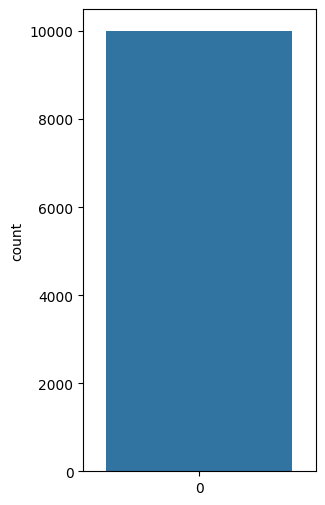

In [80]:
plt.figure(figsize=(3,6))
sns.countplot(data1.cluster)
a = data1.cluster.value_counts()[1]/len(data1.cluster)
b = data1.cluster.value_counts()[0]/len(data1.cluster)
c = data1.cluster.value_counts()[2]/len(data1.cluster)
print(f'le pourcentage du cluster[1] est: {a}')
print(f'le pourcentage du cluster[0] est: {b}')
print(f'le pourcentage du cluster[2] est: {c}')

/shared-libs/python3.9/py/lib/python3.9/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


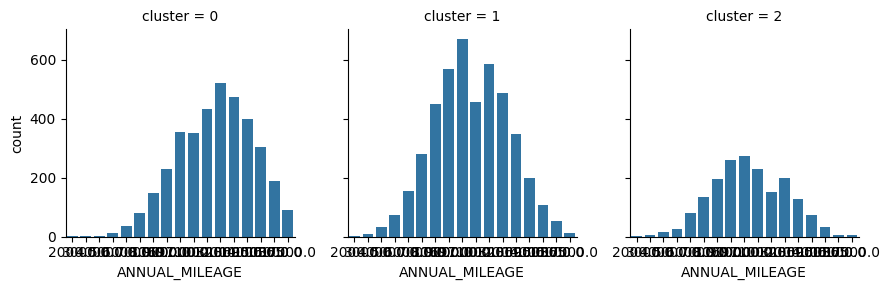

In [81]:
# Historique de crédit
grid = sns.FacetGrid(data1,col='cluster')
grid.map(sns.countplot,'ANNUAL_MILEAGE')

In [88]:
# Historique de crédit
#data1['CREDIT_SCORE'] = pd.to_numeric(data1['CREDIT_SCORE'])
data1['CREDIT_SCORE'] = data1['CREDIT_SCORE'] * 100
grid = sns.FacetGrid(data1,col='cluster')
grid.map(sns.countplot,'CREDIT_SCORE')

/shared-libs/python3.9/py/lib/python3.9/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=31be5fa6-4973-4b04-b1ef-51838847edb5' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>